<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Syntetic-tests-of-cuda-vs-numpy-vs-torch" data-toc-modified-id="Syntetic-tests-of-cuda-vs-numpy-vs-torch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Syntetic tests of cuda vs numpy vs torch</a></span></li></ul></div>

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import scripts.utils as ising

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
have_cuda = torch.cuda.is_available()
# If ever run this script beter have CUDA
if not have_cuda:
    raise('CUDA not available!')
else:
    print('CUDA ok!')

CUDA ok!


## Syntetic tests of cuda vs numpy vs torch

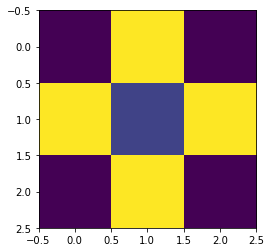

In [10]:
J = .5
mu = 0.1
nn_mask = np.array([
     [0, J, 0]
    ,[J, mu, J]
    ,[0, J, 0]
])
plt.imshow(nn_mask)

In [37]:
def get_conv_torch(mask):
    in_chan, out_chan = 1, 1
    shape = mask.shape
    l = torch.nn.Conv2d(in_chan, out_chan, shape
                        , stride=shape
                        , padding=0
                        , bias = False
                       )
    l.weight.data = torch.from_numpy(mask[np.newaxis, np.newaxis, ...])
    return l

def cuda_contr(grid, mask):
    conv = get_conv_torch(mask)
    return conv(grid)
    

    
grid = ising.get_random_grid(50)
gpu_grid = torch.from_numpy(grid[np.newaxis, np.newaxis,...]).double()
%timeit c = cuda_contr(gpu_grid, nn_mask)
im = c.detach().numpy()[0,0]

108 µs ± 9.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


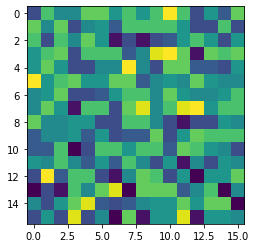

In [38]:
plt.imshow(im)

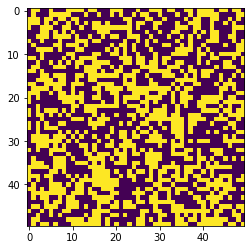

In [35]:
plt.imshow(grid)